In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
import keras

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Input, Conv2D, MaxPool2D , Flatten
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import imageio
import glob

In [4]:
from keras.datasets import mnist


In [5]:
def GANGenerator():
    model = Sequential()
    
    inputDim = 100
    outputDim = (28,28,1)
    
    model.add(Dense(256, input_dim=inputDim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
        
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(outputDim), activation='tanh'))    
    model.add(Reshape(outputDim))
    
    #model.summary()
    
    #noise = Input()
    
    return model

In [6]:
def GANDiscriminator():
    model = Sequential()
        
    imgDim = (28,28,1)
    
    model.add(Flatten(input_shape=imgDim))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation='sigmoid'))    
    
    #model.summary()
    
    return model

In [7]:
def GANcombined(G,D):
    model = Sequential()
    
    model.add(G)
    
    D.trainable = False
    model.add(D)
    
    #model.summary()
    
    return model

In [8]:
def sample_images(epoch, inputDim, gen):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, inputDim))
    gen_imgs = gen.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()
    
def save_gif():
    anim_file = 'gan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
      filenames = glob.glob('images/*.png')
      filenames = sorted(filenames)
      last = -1
      for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
      image = imageio.imread(filename)
      writer.append_data(image)

In [9]:
ad = Adam(0.0002, 0.5)

gen = GANGenerator()
#gen.compile(optimizer=ad, loss='binary_crossentropy', metrics=['accuracy'])

dis = GANDiscriminator();
dis.compile(optimizer=ad, loss='binary_crossentropy', metrics=['accuracy'])

combined = GANcombined(gen, dis)
combined.compile(optimizer=ad, loss='binary_crossentropy', metrics=['accuracy'])

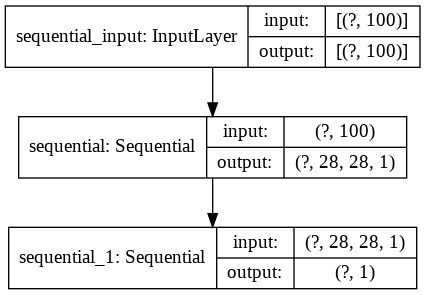

In [10]:
plot_model(gen, to_file='gan_gen.png', show_shapes=True)
plot_model(dis, to_file='gan_dis.png', show_shapes=True)
plot_model(combined, to_file='gan_combined.png', show_shapes=True)

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

batch_size = 32
inputDim = 100
sample_interval = 100


# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(30000):   

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, inputDim))

        # Generate a batch of new images
        gen_imgs = gen.predict(noise)

        # Train the discriminator
        d_loss_real = dis.train_on_batch(imgs, valid)
        d_loss_fake = dis.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, inputDim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch, inputDim, gen)

In [13]:
save_gif()